### Importing necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,SimpleRNN
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

### Load Dataset

In [17]:
dataset = pd.read_csv("/content/IBM_2006-01-01_to_2018-01-01.csv", index_col="Date", parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [14]:
dataset.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=3020, freq=None)

In [20]:
training_set = dataset[:'2017'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

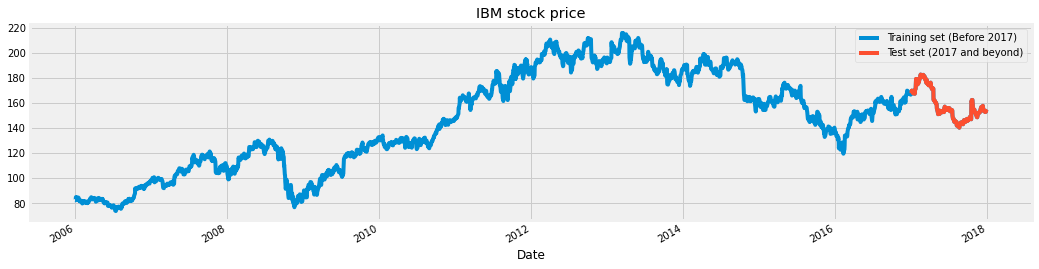

In [43]:
dataset["High"][:'2017'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [23]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [24]:
X_train = []
y_train = []
for i in range(60,1250):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [25]:
i=100
training_set_scaled[i-60:i,0].shape

(60,)

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [29]:
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

#MODEL BUILDING

In [33]:
model = Sequential()
# First GRU layer with Dropout regularisation
model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))
# Second GRU layer
model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))
# Third GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))
# Fourth GRU layer
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 60, 50)            2600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 60, 50)            5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

In [36]:
# Compiling the GRU
model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
8/8 [==============================] - 6s 166ms/step - loss: 0.0252
Epoch 2/50
8/8 [==============================] - 1s 166ms/step - loss: 0.0130
Epoch 3/50
8/8 [==============================] - 1s 165ms/step - loss: 0.0088
Epoch 4/50
8/8 [==============================] - 1s 167ms/step - loss: 0.0071
Epoch 5/50
8/8 [==============================] - 1s 167ms/step - loss: 0.0054
Epoch 6/50
8/8 [==============================] - 1s 164ms/step - loss: 0.0043
Epoch 7/50
8/8 [==============================] - 1s 174ms/step - loss: 0.0044
Epoch 8/50
8/8 [==============================] - 1s 164ms/step - loss: 0.0040
Epoch 9/50
8/8 [==============================] - 1s 169ms/step - loss: 0.0036
Epoch 10/50
8/8 [==============================] - 1s 172ms/step - loss: 0.0034
Epoch 11/50
8/8 [==============================] - 1s 162ms/step - loss: 0.0033
Epoch 12/50
8/8 [==============================] - 1s 166ms/step - loss: 0.0031
Epoch 13/50
8/8 [==============================] 

In [37]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [41]:
def predictions_plot(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

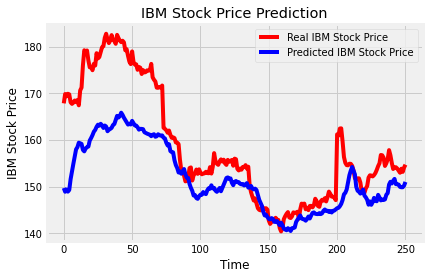

In [42]:
predictions_plot(test_set,GRU_predicted_stock_price)

### Model Evaluation

In [44]:
rmse_return(test_set,GRU_predicted_stock_price)

The root mean squared error is 9.173292235908283.
